### Char RNN

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt


### read in file

In [6]:
import os
import numpy as np

ori_file_name = 'tinyshakespeare.txt'
train_file_name = 'train_text.txt'
valid_file_name = 'valid_text.txt'

split_file_train = False
split_file_valid = False

if not os.path.exists(ori_file_name):
    raise Exception(ori_file_name + ' file not found!')
    
else:
    
    ori_line_len = len(open(ori_file_name).readlines())
    ori_len = len(open(ori_file_name).read())
    file_read = open(ori_file_name, 'r')
    
    if not os.path.exists(train_file_name):
        
        split_file_train = True
        file_train = open(train_file_name,'w')
        
    if not os.path.exists(valid_file_name):
        
        split_file_valid = True
        file_valid = open(valid_file_name,'w')
    
    char_cnt = 0
    print('Train data need rebuilt: ', split_file_train)
    print('Valid data need rebuilt: ', split_file_valid)
    
    if split_file_train or split_file_valid:
        for char in file_read:
            '''
            print(char_cnt)
            print(char)
            '''
            if split_file_train and char_cnt <= np.ceil(ori_line_len * 0.7):
                file_train.write(char.strip() + ' ')
                char_cnt += 1

            elif split_file_valid and char_cnt >= np.ceil(ori_line_len * 0.7):
                file_valid.write(char.strip() + ' ')
                char_cnt += 1
    
    file_read.close()
    
    if split_file_train:
        file_train.close()
    if split_file_valid:
        file_valid.close()

### test file written

file_train = open(train_file_name).read()
file_valid = open(valid_file_name).read()

len_dict = {}

len_dict['file_train_len'] = len(file_train)
len_dict['file_valid_len'] = len(file_valid)

print('file_input_line_len', ori_line_len)
print('file_input_len ', ori_len)
print('file_train_len ',len_dict['file_train_len'])
print('file_valid_len ',len_dict['file_valid_len'])

Train data need rebuilt:  True
Valid data need rebuilt:  True
file_input_line_len 40000
file_input_len  1115390
file_train_len  799485
file_valid_len  315905


### Define LSTM RNN

In [4]:
class LSTM_RNN(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 input_lstm_size = 75,
                 hidden_size = 64,
                 batch_size = 20,
                 n_layers = 1,
                 ):
        
        super(LSTM_RNN, self).__init__()
        
        self.input_size = input_size
        self.input_lstm_size = input_lstm_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.embeds = nn.Embedding(self.input_size,
                                   self.input_lstm_size)
        
        self.lstm_rnn = nn.LSTM(input_size = self.input_lstm_size,
                                hidden_size = self.hidden_size,
                                num_layers = self.n_layers,
                                batch_first = True)
        
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, net_input, hidden):
        
        x = self.embeds(net_input)
        output, hidden = self.lstm_rnn(x.view(self.batch_size,
                                               1, -1),
                                               hidden)
        output = self.fc(output.view(batch_size, -1))
        return output, hidden
        
        
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers,
                              batch_size,
                              self.hidden_size).to(device),
                  torch.zeros(self.n_layers,
                              batch_size,
                              self.hidden_size).to(device))
    

In [5]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for str_idx in range(len(string)):
        try:
            tensor[str_idx] = ord(string[str_idx])
        except:
            continue
            
    return tensor

def random_seq_extract(file, file_str, chunk_len, batch_size):
    
    inp_seq = torch.LongTensor(batch_size, chunk_len)
    tar_seq = torch.LongTensor(batch_size, chunk_len)
    
    for batch_idx in range(batch_size):
        start_rand = random.randint(0, len_dict[file_str + '_len'] - chunk_len - 1)
        end_rand = start_rand + chunk_len + 1
        
        chunk_temp = file[start_rand : end_rand]
        
        inp_seq[batch_idx,:] = char_tensor(chunk_temp[:-1])
        tar_seq[batch_idx,:] = char_tensor(chunk_temp[1:])
        
    inp_seq = inp_seq.to(device)
    tar_seq = tar_seq.to(device)
    
    return inp_seq, tar_seq
    
        

In [6]:
def train(inp_seq, tar_seq):
    hidden = Rnn_net.init_hidden(batch_size)
    
    Rnn_net.zero_grad()
    loss = 0
    
    for str_idx in range(chunk_len):
        output, hidden = Rnn_net.forward(inp_seq[:,str_idx], hidden)
        
        loss += criterion(output.view(batch_size, -1), tar_seq[:, str_idx])
        
    loss.backward()
    optimizer.step()
                          
    return loss.item() / (chunk_len * batch_size)


def valid(inp_seq, tar_seq):
    hidden = Rnn_net.init_hidden(batch_size)
    
    Rnn_net.zero_grad()
    loss = 0
    
    for str_idx in range(chunk_len):
        output, hidden = Rnn_net.forward(inp_seq[:,str_idx], hidden)
        loss += criterion(output.view(batch_size, -1), tar_seq[:, str_idx])
                          
    return loss.item() / (chunk_len * batch_size)
        
    


In [7]:
def generate(model, prime_str = 'A', predict_len = 800, temperature = 1):
    hidden = model.init_hidden(1)
    prime_input = char_tensor(prime_str).unsqueeze(0)
    
    prime_input = prime_input.to(device)
    predicted = prime_str
    
    for p_idx in range(len(prime_str) - 1):
        _, hidden = model(prime_input[:,p_idx], hidden)
        
    inp = prime_input[:,-1]
    
    for p_idx in range(predict_len):
        output, hidden = model.forward(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        predict_char = chr(torch.multinomial(output_dist, 1)[0])
        
        #predict_char = chr(torch.argmax(output).cpu().item())
        
        predicted += predict_char
        inp = char_tensor(predict_char).unsqueeze(0).to(device)
    
    return predicted
    

def save_checkpointsave (state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

### Main cell

In [41]:

epoch_m = 2500
chunk_len = 100 # sequence chunk extract from text.

### net work parameters initializaiton

batch_size = 20
input_size = 128
input_lstm_size = 75
output_size = input_size
hidden_size = 100
n_layers = 2

### about learning rate
learn_init = 0.001
lr_change = False
lr_T = 400

### Phase = Train / Generate
Phase = 'Generate'

Rnn_net = LSTM_RNN(input_size = input_size,
                   output_size = output_size,
                   input_lstm_size = input_lstm_size,
                   hidden_size = hidden_size,
                   batch_size = batch_size,
                   n_layers = n_layers)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is',device)

Rnn_net.to(device)

optim_model = 'Adam'

if optim_model == 'Adam':
    optimizer = torch.optim.Adam(Rnn_net.parameters(), lr = learn_init)
    
else:
    raise Exception('Wrong optimizer!')
    
    
criterion = nn.CrossEntropyLoss()


if Phase == 'Train':
    
    loss_train_lst = []
    loss_valid_lst = []

    for epoch in tqdm(range(epoch_m)):
        
        if lr_change == True:
            learn_r = learn_init / (1 + epoch / T)
            
            if model_optim == 'Adam':
                optimizer = torch.optim.Adam(Rnn_net.parameters(), lr = learn_r)
                
           
        loss_train = train(*random_seq_extract(file_train, 'file_train', chunk_len, batch_size))
        loss_train_lst.append(loss_train)
        
        loss_valid = valid(*random_seq_extract(file_valid, 'file_valid', chunk_len, batch_size))
        loss_valid_lst.append(loss_valid)
        '''
        print('Epoch is ', epoch)
        print('Loss_train:', loss_train, ' / Loss_valid:', loss_valid)
        '''
    save_checkpointsave ({'net_dict': Rnn_net.state_dict()},
                         filename='checkpoint.pth.tar')
    
elif Phase == 'Generate':
    
    checkpoint = torch.load('checkpoint.pth.tar')
    prime_str = 'I '
    predict_len = 1000
    batch_size = 1
    temperature = 1
    
    
    Rnn_lstm = LSTM_RNN(input_size = input_size,
                   output_size = output_size,
                   input_lstm_size = input_lstm_size,
                   hidden_size = hidden_size,
                   batch_size = batch_size,
                   n_layers = n_layers)
    
    Rnn_lstm.load_state_dict(checkpoint['net_dict'])
    Rnn_lstm.to(device)
    
    generated = generate(Rnn_lstm,
                         prime_str = prime_str,
                         predict_len = predict_len,
                         temperature = temperature)
    print(generated)

else:
    raise Exception('Not a valid phase!')




device is cuda:0
I consely'd than you nosest moates, In there be hacly wild Lencle not spoy my clain.  Tharry-duster yoo, for Shew whose my sunners with sainks thack, In Romeo to bring, and roud blouds born villy, you sauch a wimer hamed: I diy.  LERYI: That neghlitte, 'Gay, Thou be onged to heart. Thas death!  RICHARD: You boysenk of Whre having artand the, use: Come the lopt will Havese-creightatest of For gowl'd I handy, Which pimhelf be grest Your be thou frominf I so brown there!  MARCGALON: The but in, me?  COMINIUS: O' taty from I pits for to hinging lord on voiginnom jonour's Torny I querity beakal; You greas, they seble,  Turdering To hoacher is a ghy mon Thim.  Firss, And des'd, and do your how, gave sand Murderer? and oursead?  ROMIO: So fauthers?  ROMEO: Sway, it, not then this have shum; founce, with up the of herful ampmon with his alage.  AUCIOLUUS: On as you nog and less to manded: Neceet tuse.  HENRY RLILARY:, I ald Boiscesp not Edward his have heas for you yourseld Is

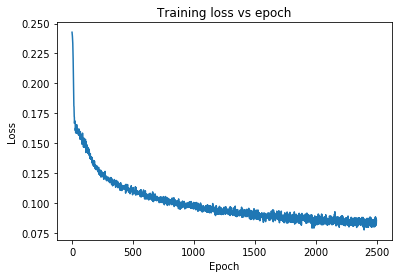

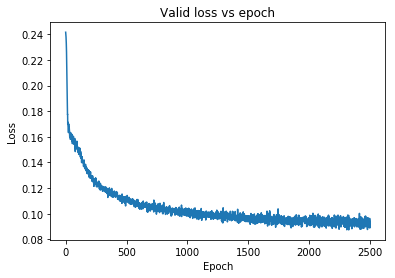

In [26]:
loss_train_lst_temp = loss_train_lst[:]
loss_valid_lst_temp = loss_valid_lst[:]

plt.figure()
plt.plot(loss_train_lst_temp)
plt.title('Training loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(loss_valid_lst)
plt.title('Valid loss vs epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
